In [5]:
import numpy,sys,matplotlib
import scanpy,velocyto

# 1. Visualization

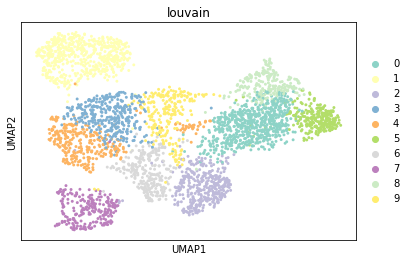

In [2]:
idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')
adata=idata.transpose()

scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

adata.obs['n_counts'] = adata.X.sum(axis=1)

scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

adata.raw = adata

scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
adata = adata[:, adata.var['highly_variable']]

scanpy.pp.regress_out(adata, ['n_counts'])
scanpy.pp.scale(adata, max_value=10)

scanpy.tl.pca(adata,svd_solver='arpack')
scanpy.pp.neighbors(adata,n_neighbors=12,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata,color=['louvain'],palette='Set3')

In [12]:
cell_cluster_map=adata.obs['louvain'].to_dict()
barcodes=[element.split('_M397')[0] for element in list(cell_cluster_map.keys())]
print(len(barcodes))
unique_barcodes=list(set(barcodes))
print(len(unique_barcodes))
print(len(unique_barcodes),unique_barcodes[:10])

3477
3471
3471 ['CGCGGTATCACATAGC', 'GAATGAAGTGATGATA', 'ACGGGCTCAGACGTAG', 'GAGGTGAGTCCAACTA', 'CACACTCAGACGCTTT', 'TAGGCATGTCGGCTCA', 'TAGAGCTGTCCTGCTT', 'ACATCAGGTCATACTG', 'CGTGTCTAGATCGGGT', 'GCGCAGTGTTGTACAC']


# 2. Velocity analysis

In [6]:
vlm=velocyto.VelocytoLoom("/Volumes/omics4tb2/alomana/projects/mscni/results/velocyto/combined.loom")

In [10]:
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > numpy.percentile(vlm.initial_Ucell_size, 0.5))
print(vlm.ca['CellID'].shape[0])

7318
['20765_M397_control:AAGACCTCAGGTCCACx'
 '20765_M397_control:AACTCAGTCACATACGx'
 '20765_M397_control:AAATGCCAGGCTCTTAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
7279


In [11]:
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > numpy.percentile(vlm.initial_Ucell_size, 0.5))
print(vlm.ca['CellID'].shape[0])

7279
['20765_M397_control:AAGACCTCAGGTCCACx'
 '20765_M397_control:AACTCAGTCACATACGx'
 '20765_M397_control:AAATGCCAGGCTCTTAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
7240


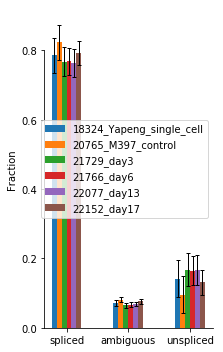

In [7]:
vlm.plot_fractions()

In [4]:
vlm.normalize("S",size=True,log=True)
vlm.normalize("U",size=True,log=False)

In [23]:
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=vlm.initial_Ucell_size > numpy.percentile(vlm.initial_Ucell_size, 0.5))
print(vlm.ca['CellID'].shape[0])

1205
['18324_Yapeng_single_cell:AAGACCTAGGGCACTAx'
 '18324_Yapeng_single_cell:AAGACCTCAAGCGAGTx'
 '18324_Yapeng_single_cell:ACACCCTTCTGAGGGAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
1197


In [6]:
vlm.score_detection_levels()
vlm.filter_genes(by_detection_levels=True)

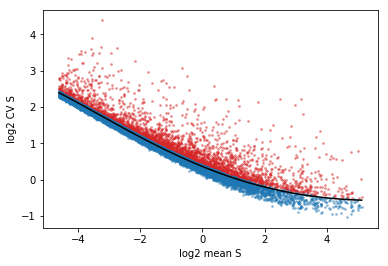

In [7]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [8]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

In [9]:
number_of_cells=vlm.ca['CellID'].shape[0]
print(number_of_cells)
nei=int(0.025*number_of_cells)

1220


In [13]:
vlm.perform_PCA(n_components=50)
print(nei)
vlm.knn_imputation(k=nei,n_pca_dims=50,balanced=True,n_jobs=8)

30


In [14]:
vlm.fit_gammas()

In [15]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [16]:
#from sklearn.manifold import TSNE
#bh_tsne = TSNE()
#vlm.ts = bh_tsne.fit_transform(vlm.pcs[:, :50])

positions=bh_tsne.fit_transform(vlm.pcs[:, :50])
print(type(positions))

In [17]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=nei, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

/Users/alomana/anaconda3/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


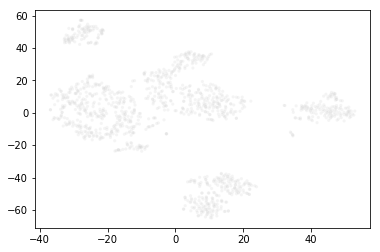

In [18]:
matplotlib.pyplot.scatter(vlm.embedding[:, 0],vlm.embedding[:, 1],c="0.8",alpha=0.2,s=10,edgecolor="")

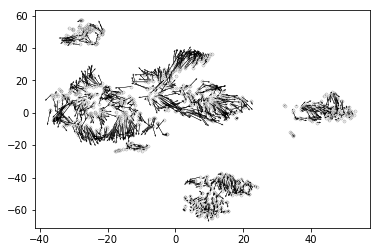

In [20]:
# overlay arrows
ix_choice = numpy.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
matplotlib.pyplot.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color='black', alpha=1)
matplotlib.pyplot.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],**quiver_kwargs)

matplotlib.pyplot.savefig('figure.pdf')